# Wine Quality Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (1599, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Head:
    fixed acidity  vo

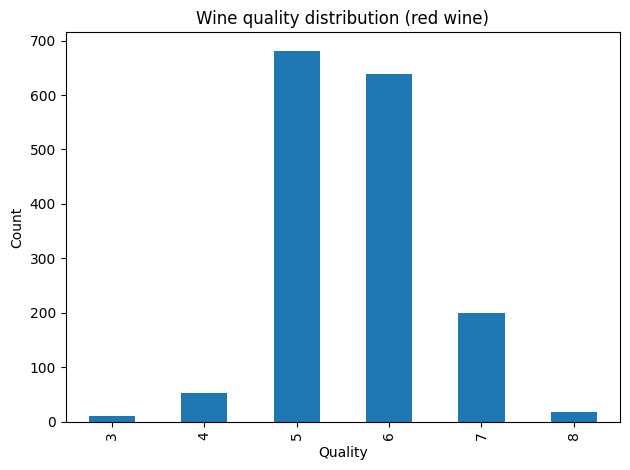

In [24]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabicl import TabICLClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#path = "./data/winequality-white.csv"
path = "./data/winequality-red.csv"
df = pd.read_csv(path, sep=";")

fname = os.path.basename(path).lower()
if "white" in fname:
    dataset_label = "white"
else:
    dataset_label = "red"

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = "quality"
quality_counts = df[target_col].value_counts().sort_index()
print("\nQuality value counts:\n", quality_counts)

feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

plt.figure()
quality_counts.plot(kind="bar")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title(f"Wine quality distribution ({dataset_label} wine)")
plt.tight_layout()
plt.show()

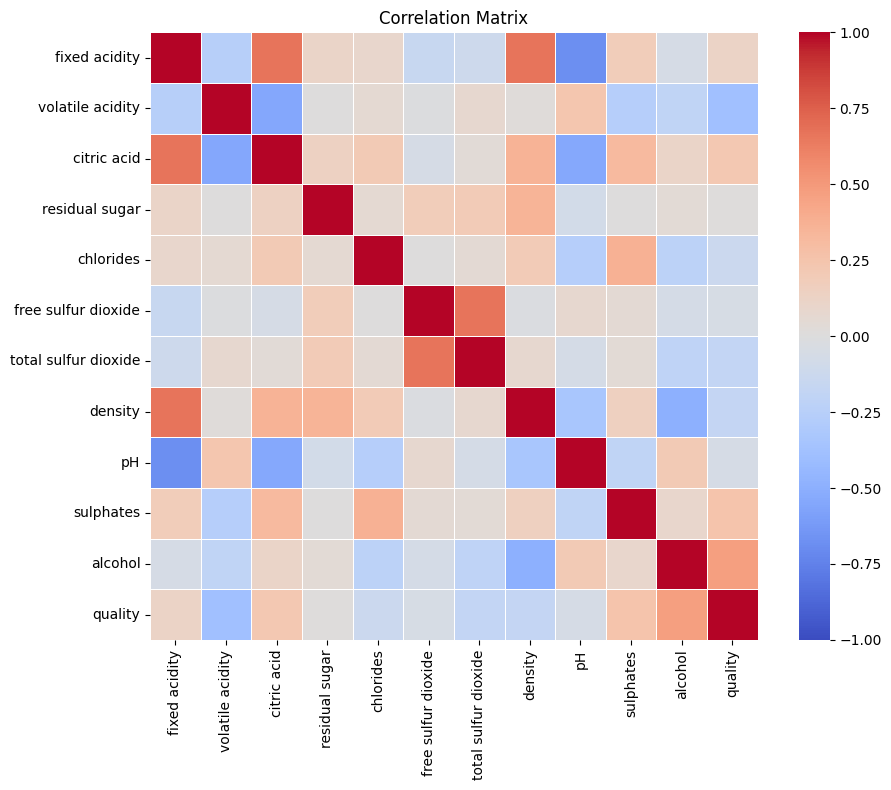

In [25]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [26]:
def timed_fit_predict(model, X_tr, y_tr, X_te):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    y_hat = model.predict(X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    return y_hat, fit_s, pred_s

### TabPFN (Regressor)

In [27]:
fold_summaries = []
all_y_true, all_y_pred = [], []

kf = KFold(n_splits=5, shuffle=True, random_state=21)

rmses, maes, r2s = [], [], []
fit_times, pred_times = [], []

warm_model = TabPFNRegressor(device="cuda")
_ = warm_model.fit(X.iloc[:256], y.iloc[:256])
_ = warm_model.predict(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    model = TabPFNRegressor(device="cuda")
    y_hat, fit_s, pred_s = timed_fit_predict(model, X_tr, y_tr, X_te)

    rmse = root_mean_squared_error(y_te, y_hat)
    mae = mean_absolute_error(y_te, y_hat)
    r2 = r2_score(y_te, y_hat)

    rmses.append(rmse); maes.append(mae); r2s.append(r2)
    fit_times.append(fit_s); pred_times.append(pred_s)

    fold_summaries.append(
        {"fold": fold, "rmse": rmse, "mae": mae, "r2": r2, "fit_s": fit_s, "pred_s": pred_s}
    )
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(np.asarray(y_hat))

    print(f"Fold {fold}: RMSE={rmse:.4f} MAE={mae:.4f} R2={r2:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

print(
    f"\nTabPFN 5-fold CV: RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f}, "
    f"MAE = {np.mean(maes):.4f} ± {np.std(maes):.4f}, "
    f"R2 = {np.mean(r2s):.4f} ± {np.std(r2s):.4f}"
)
print(
    f"Timing: fit = {np.mean(fit_times):.2f}s ± {np.std(fit_times):.2f}, "
    f"predict = {np.mean(pred_times):.2f}s ± {np.std(pred_times):.2f}"
)

Fold 1: RMSE=0.6011 MAE=0.4769 R2=0.4581 | fit=0.221s pred=0.674s
Fold 2: RMSE=0.6020 MAE=0.4566 R2=0.4439 | fit=0.217s pred=0.546s
Fold 3: RMSE=0.6309 MAE=0.4820 R2=0.4008 | fit=0.195s pred=0.576s
Fold 4: RMSE=0.6135 MAE=0.4596 R2=0.4158 | fit=0.220s pred=0.539s
Fold 5: RMSE=0.6002 MAE=0.4668 R2=0.4235 | fit=0.218s pred=0.533s

TabPFN 5-fold CV: RMSE = 0.6096 ± 0.0117, MAE = 0.4684 ± 0.0097, R2 = 0.4284 ± 0.0203
Timing: fit = 0.21s ± 0.01, predict = 0.57s ± 0.05


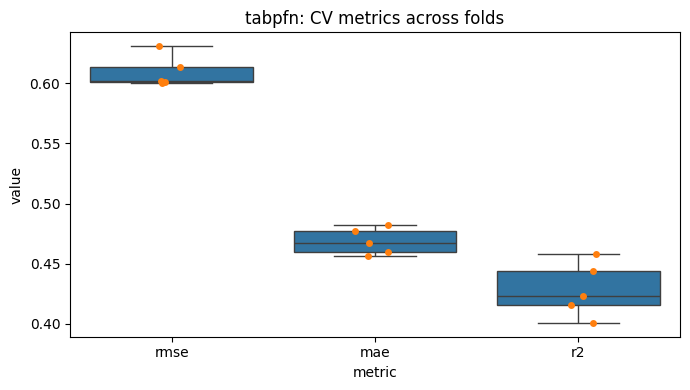

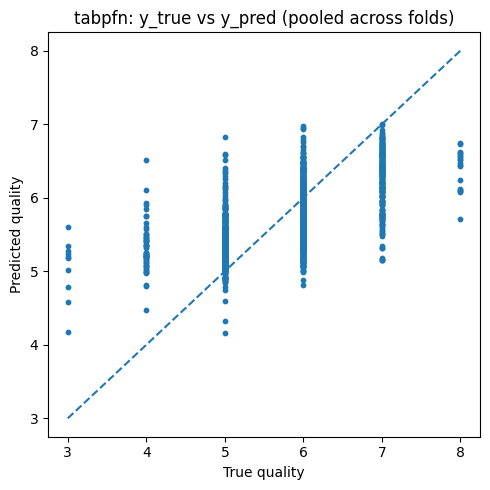

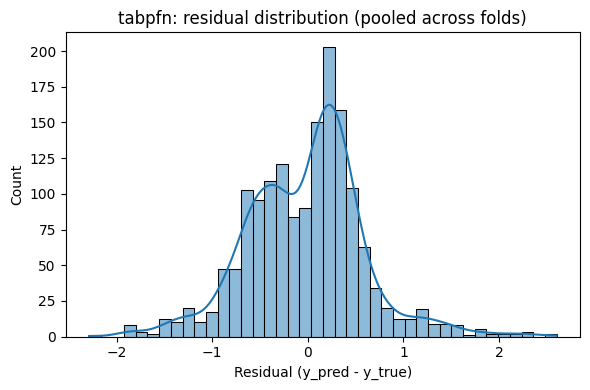

In [28]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": pd.DataFrame(fold_summaries),
    "y_true_cv": np.concatenate(all_y_true).astype(float),
    "y_pred_cv": np.concatenate(all_y_pred).astype(float),
}

cv_metrics_df = MODEL_RESULTS[model_name]["cv_metrics_df"]
y_true_cv = MODEL_RESULTS[model_name]["y_true_cv"]
y_pred_cv = MODEL_RESULTS[model_name]["y_pred_cv"]

cv_metrics_long_df = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["rmse", "mae", "r2"],
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=cv_metrics_long_df, x="metric", y="value")
sns.stripplot(data=cv_metrics_long_df, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_true_cv, y_pred_cv, s=10)
mn = float(min(y_true_cv.min(), y_pred_cv.min()))
mx = float(max(y_true_cv.max(), y_pred_cv.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title(f"{model_name}: y_true vs y_pred (pooled across folds)")
plt.tight_layout()
plt.show()

residuals_cv = y_pred_cv - y_true_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals_cv, bins=40, kde=True)
plt.xlabel("Residual (y_pred - y_true)")
plt.title(f"{model_name}: residual distribution (pooled across folds)")
plt.tight_layout()
plt.show()


## Plot Function

In [29]:
def plot_model_results(model_name):
    res = MODEL_RESULTS[model_name]
    cv_metrics_df = res["cv_metrics_df"]
    y_true_cv = res["y_true_cv"]
    y_pred_cv = res["y_pred_cv"]
    y_proba_cv = res["y_proba_cv"]
    dataset = res.get("dataset", "unknown dataset")

    metrics_long = cv_metrics_df.melt(
        id_vars=["fold"],
        value_vars=["acc", "auc"],
        var_name="metric",
        value_name="value",
    )
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=metrics_long, x="metric", y="value")
    sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
    plt.title(f"{model_name} ({dataset}): CV metrics across folds")
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true_cv, y_pred_cv)
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} ({dataset}): Confusion matrix (pooled)")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"{model_name} ({dataset}): ROC curve (pooled)")
    plt.tight_layout()
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
    ap = average_precision_score(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} ({dataset}): Precision–Recall curve (AP={ap:.3f})")
    plt.tight_layout()
    plt.show()

    bins = np.linspace(0.0, 1.0, 11)
    bin_ids = np.digitize(y_proba_cv, bins) - 1

    bin_centers, frac_pos = [], []
    for b in range(len(bins) - 1):
        m = bin_ids == b
        if m.sum() == 0:
            continue
        bin_centers.append((bins[b] + bins[b + 1]) / 2)
        frac_pos.append(y_true_cv[m].mean())

    plt.figure(figsize=(5, 4))
    plt.plot(bin_centers, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Predicted probability (bin center)")
    plt.ylabel("Empirical P(y=1)")
    plt.title(f"{model_name} ({dataset}): Reliability curve (pooled)")
    plt.tight_layout()
    plt.show()

### TabPFN (Classifier)

In [30]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

warm_model = TabPFNClassifier(device="cuda")
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = get_pos_proba(warm_model, X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabPFNClassifier(device="cuda")

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)


Positive rate (quality>=7): 0.1357098186366479
Majority baseline accuracy: 0.8642901813633521
Fold 1: ACC=0.9125 AUC=0.9174 | fit=0.218s pred=0.613s
Fold 2: ACC=0.9313 AUC=0.9451 | fit=0.191s pred=0.594s
Fold 3: ACC=0.8844 AUC=0.9076 | fit=0.194s pred=0.599s
Fold 4: ACC=0.8750 AUC=0.9283 | fit=0.186s pred=0.594s
Fold 5: ACC=0.9091 AUC=0.9318 | fit=0.186s pred=0.666s

tabpfn 5-fold CV: ACC=0.9024±0.0227, AUC=0.9260±0.0143
Timing: fit=0.20s±0.01, predict=0.61s±0.03


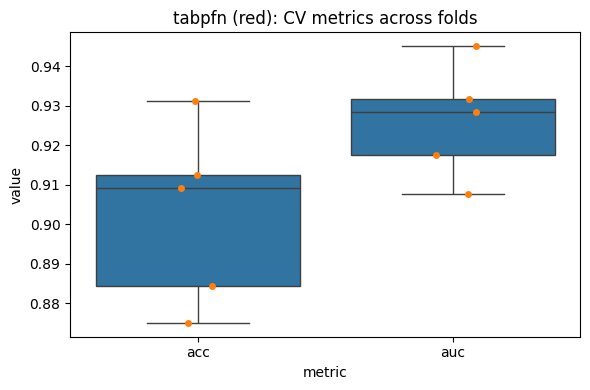

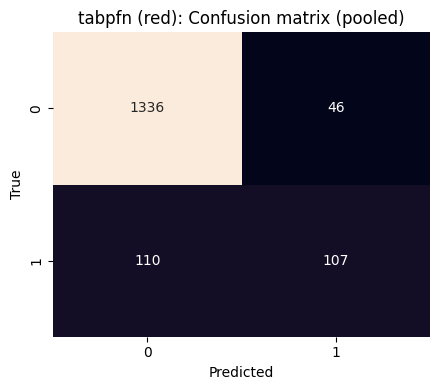

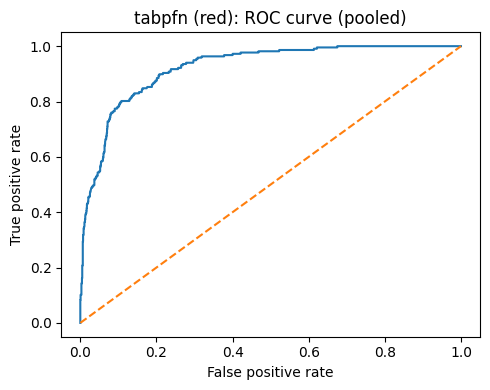

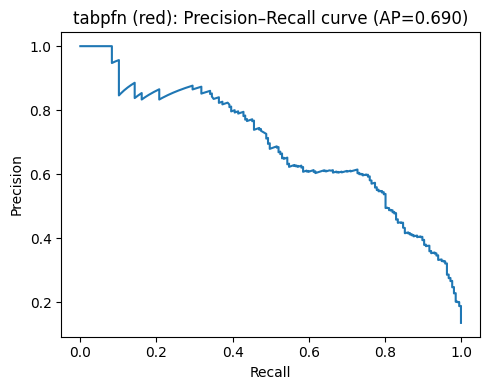

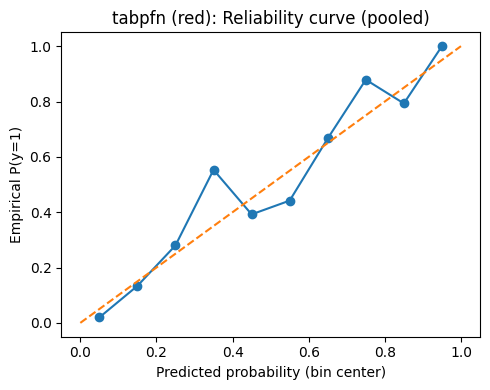

In [31]:
plot_model_results("tabpfn")

### TabICL

In [32]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabicl"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

warm_model = TabICLClassifier()
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = get_pos_proba(warm_model, X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabICLClassifier()

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)


Positive rate (quality>=7): 0.1357098186366479
Majority baseline accuracy: 0.8642901813633521
Fold 1: ACC=0.9125 AUC=0.9349 | fit=0.379s pred=0.875s
Fold 2: ACC=0.9406 AUC=0.9578 | fit=0.361s pred=0.875s
Fold 3: ACC=0.8938 AUC=0.9256 | fit=0.364s pred=0.894s
Fold 4: ACC=0.8906 AUC=0.9386 | fit=0.367s pred=0.876s
Fold 5: ACC=0.9185 AUC=0.9519 | fit=0.371s pred=0.873s

tabicl 5-fold CV: ACC=0.9112±0.0203, AUC=0.9418±0.0130
Timing: fit=0.37s±0.01, predict=0.88s±0.01


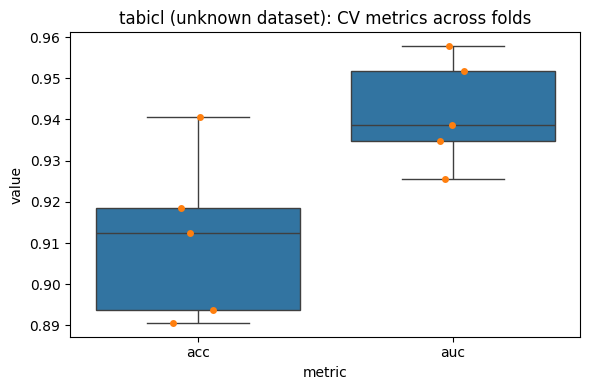

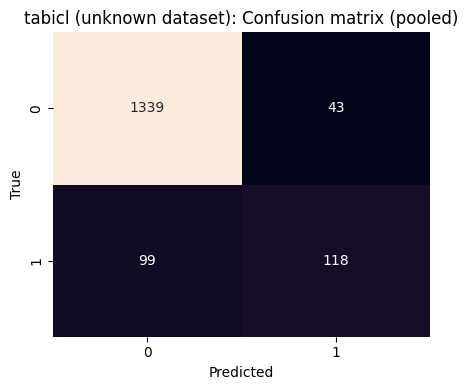

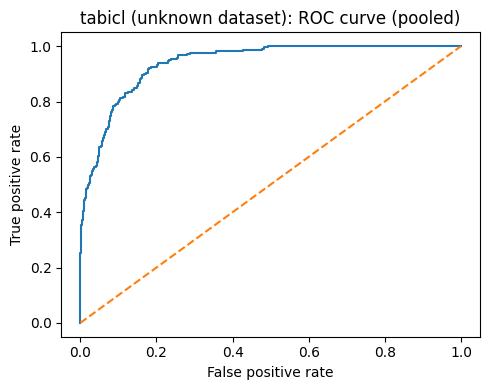

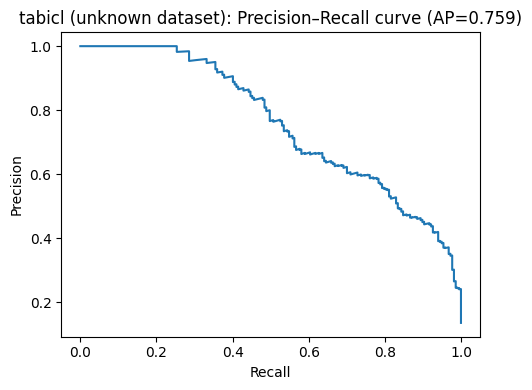

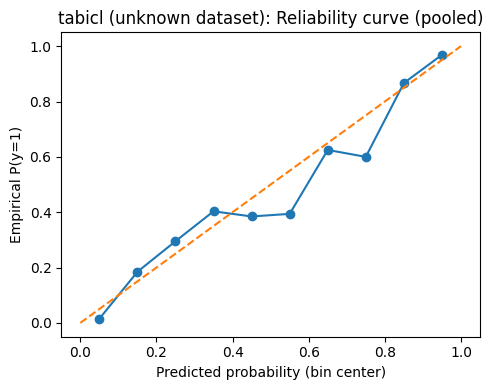

In [33]:
plot_model_results("tabicl")

### Random Forest, XGBoost, CatBoost and LightGBM

In [34]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))
print(55 * "-")

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def _get_pos_proba(model, X_te):
    proba = model.predict_proba(X_te)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

def run_cv(model_name, make_model):
    fold_summaries = []
    all_y_true, all_y_pred, all_y_proba = [], [], []

    warm = make_model()
    warm.fit(X.iloc[:256], y_bin.iloc[:256])
    _ = _get_pos_proba(warm, X.iloc[:256])

    for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()

        t0 = time.perf_counter()
        model.fit(X_tr, y_tr)
        fit_s = time.perf_counter() - t0

        t0 = time.perf_counter()
        proba = _get_pos_proba(model, X_te)
        pred_s = time.perf_counter() - t0

        y_hat = (proba >= 0.5).astype(int)

        acc = accuracy_score(y_te, y_hat)
        auc = roc_auc_score(y_te, proba)

        fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
        all_y_true.append(y_te.to_numpy())
        all_y_pred.append(y_hat)
        all_y_proba.append(proba)

        print(f"{model_name} Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

    cv_metrics_df = pd.DataFrame(fold_summaries)
    y_true_cv = np.concatenate(all_y_true)
    y_pred_cv = np.concatenate(all_y_pred)
    y_proba_cv = np.concatenate(all_y_proba)

    MODEL_RESULTS[model_name] = {
        "cv_metrics_df": cv_metrics_df,
        "y_true_cv": y_true_cv,
        "y_pred_cv": y_pred_cv,
        "y_proba_cv": y_proba_cv,
    }

    print(
        f"\n{model_name} 5-fold CV: "
        f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
        f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
    )
    print(
        f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
        f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
    )
    print(55 * "-")

models_to_run = {}

models_to_run["rf"] = lambda: RandomForestClassifier(random_state=20, n_jobs=-1)

models_to_run["xgb"] = lambda: XGBClassifier(random_state=20, n_jobs=-1)

models_to_run["cat"] = lambda: CatBoostClassifier(random_seed=20, verbose=False)

models_to_run["lgbm"] = lambda: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1)

for name, factory in models_to_run.items():
    run_cv(name, factory)

Positive rate (quality>=7): 0.1357098186366479
Majority baseline accuracy: 0.8642901813633521
-------------------------------------------------------
rf Fold 1: ACC=0.9000 AUC=0.9080 | fit=0.273s pred=0.051s
rf Fold 2: ACC=0.9437 AUC=0.9575 | fit=0.270s pred=0.049s
rf Fold 3: ACC=0.9062 AUC=0.8923 | fit=0.258s pred=0.050s
rf Fold 4: ACC=0.8969 AUC=0.9374 | fit=0.263s pred=0.050s
rf Fold 5: ACC=0.9185 AUC=0.9393 | fit=0.257s pred=0.051s

rf 5-fold CV: ACC=0.9131±0.0190, AUC=0.9269±0.0263
Timing: fit=0.26s±0.01, predict=0.05s±0.00
-------------------------------------------------------
xgb Fold 1: ACC=0.8969 AUC=0.9115 | fit=0.032s pred=0.002s
xgb Fold 2: ACC=0.9500 AUC=0.9534 | fit=0.031s pred=0.002s
xgb Fold 3: ACC=0.8719 AUC=0.8866 | fit=0.028s pred=0.001s
xgb Fold 4: ACC=0.8969 AUC=0.9211 | fit=0.032s pred=0.002s
xgb Fold 5: ACC=0.9216 AUC=0.9326 | fit=0.029s pred=0.002s

xgb 5-fold CV: ACC=0.9075±0.0296, AUC=0.9210±0.0248
Timing: fit=0.03s±0.00, predict=0.00s±0.00
------------------

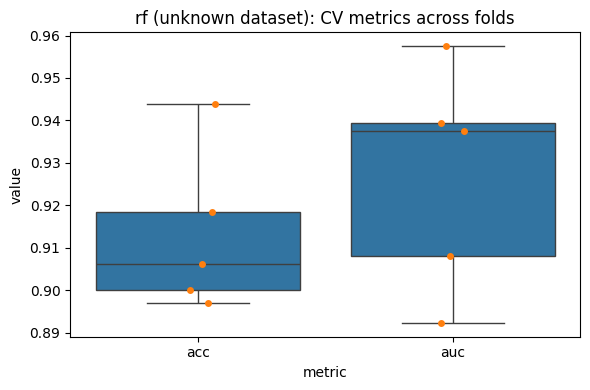

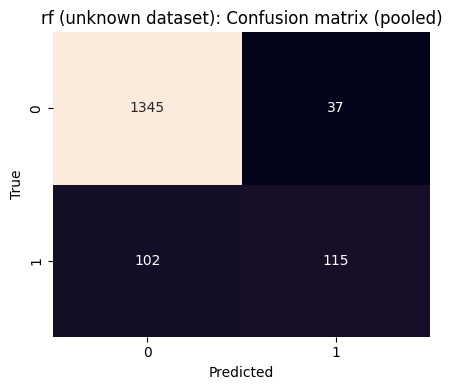

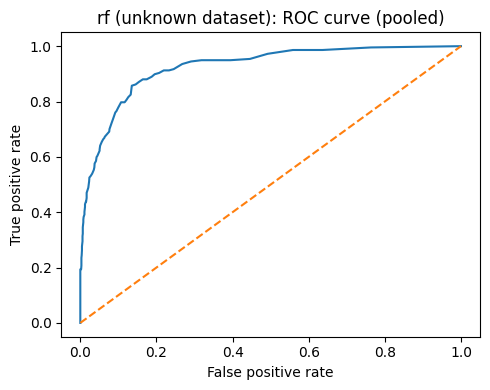

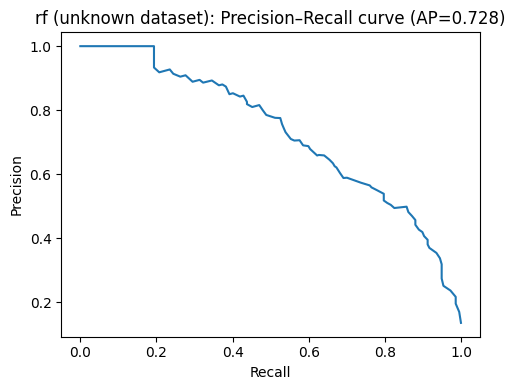

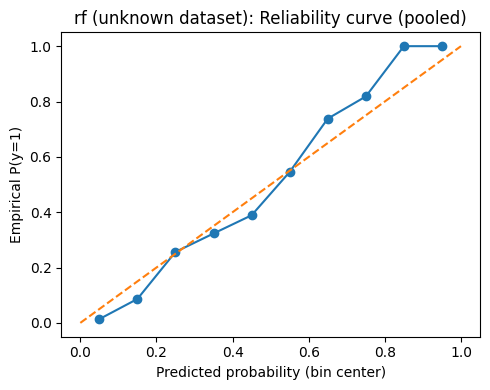

In [35]:
plot_model_results("rf")

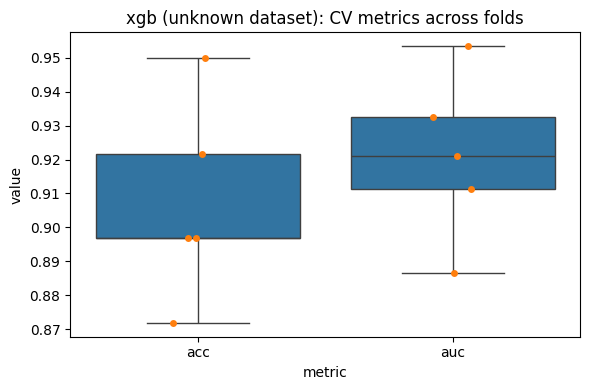

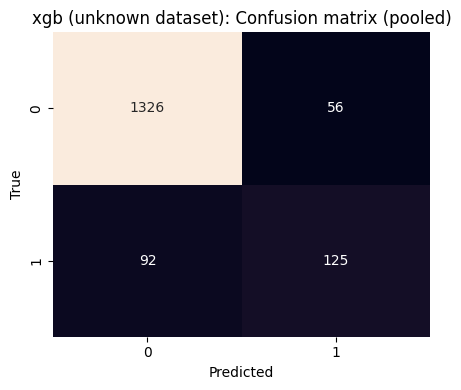

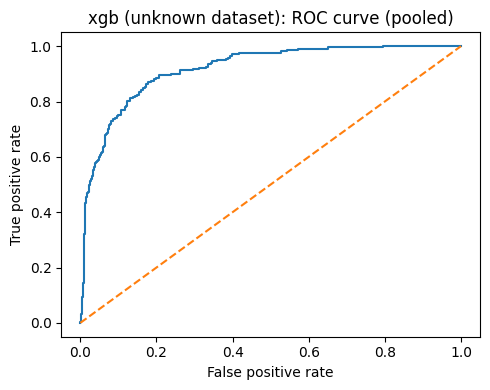

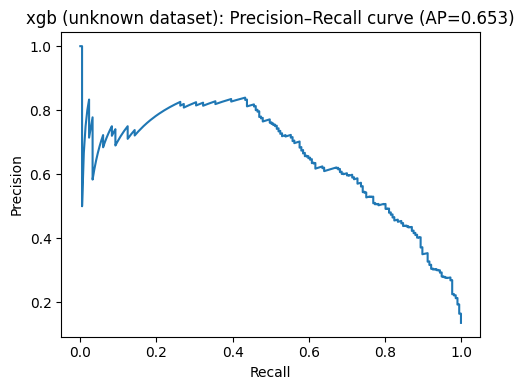

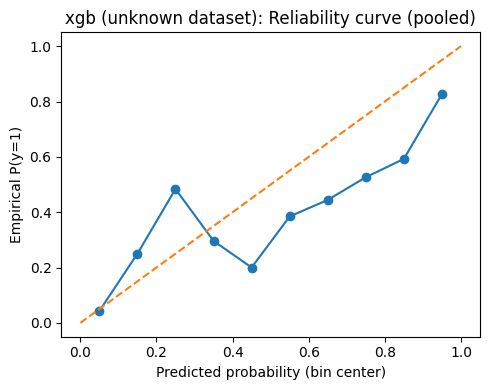

In [36]:
plot_model_results("xgb")

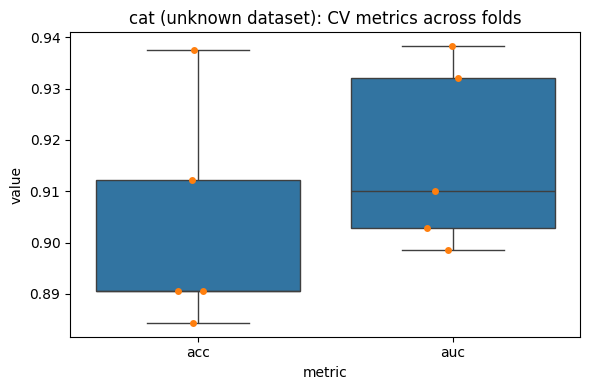

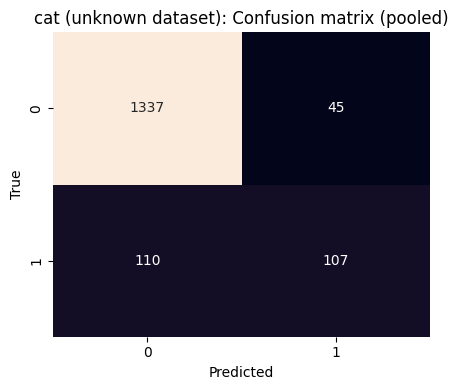

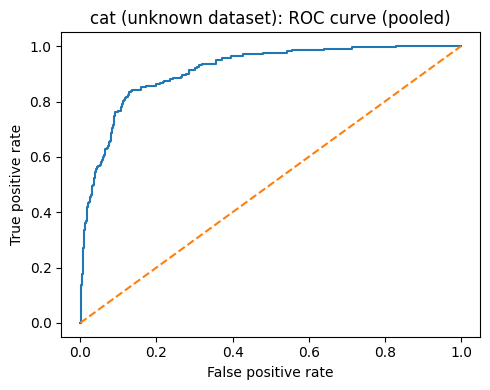

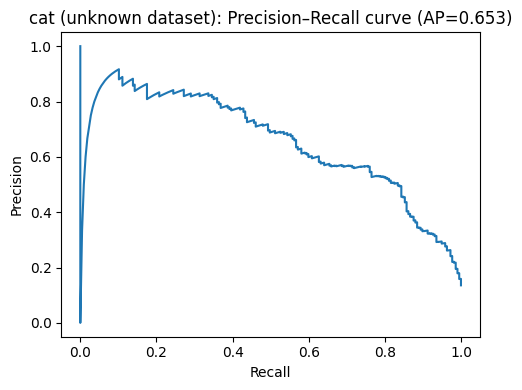

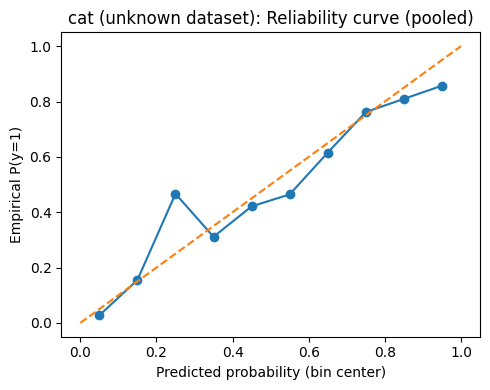

In [37]:
plot_model_results("cat")

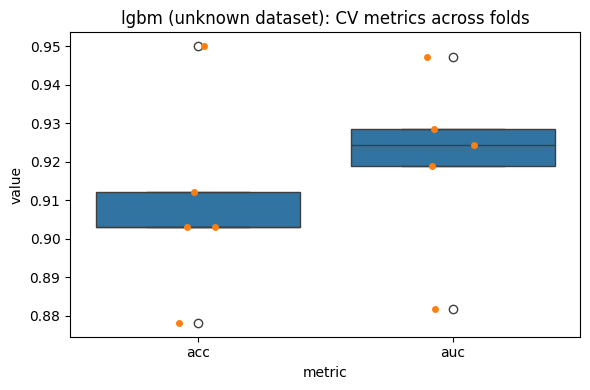

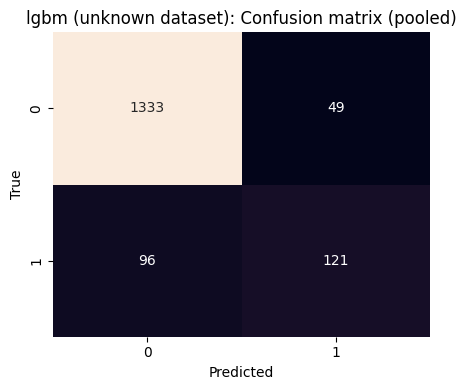

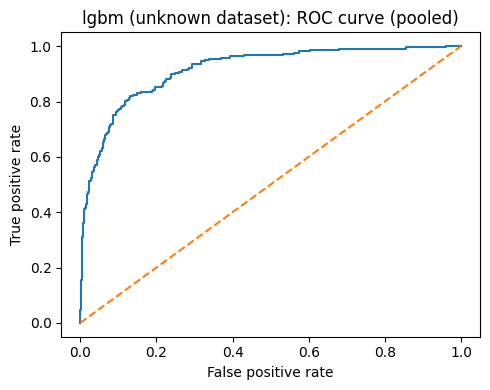

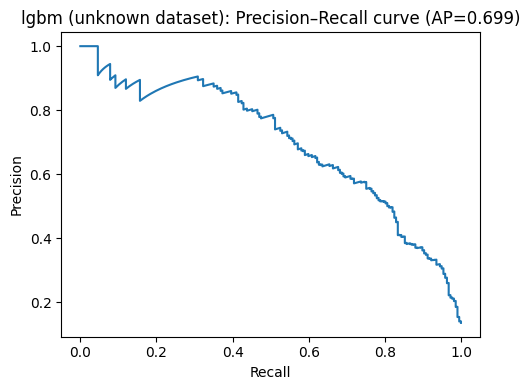

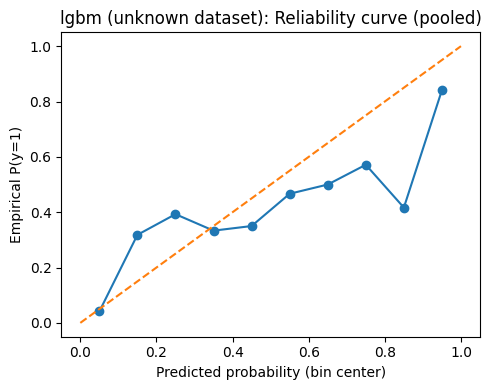

In [38]:
plot_model_results("lgbm")

In [39]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df", None)
    if cv is None or cv.empty:
        continue
    rows.append({
        "model": name,
        "acc_mean": cv["acc"].mean(),
        "acc_std": cv["acc"].std(ddof=1),
        "auc_mean": cv["auc"].mean(),
        "auc_std": cv["auc"].std(ddof=1),
        "fit_s_mean": cv["fit_s"].mean() if "fit_s" in cv.columns else None,
        "pred_s_mean": cv["pred_s"].mean() if "pred_s" in cv.columns else None,
        "n_folds": int(cv.shape[0]),
    })

summary_df = pd.DataFrame(rows).sort_values("auc_mean", ascending=False).reset_index(drop=True)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].astype(float)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabicl,0.9112,0.0203,0.9418,0.0130,0.368,0.878,5
1,rf,0.9131,0.0190,0.9269,0.0263,0.264,0.050,5
2,tabpfn,0.9024,0.0227,0.9260,0.0143,0.195,0.613,5
3,xgb,0.9075,0.0296,0.9210,0.0248,0.031,0.002,5
4,lgbm,0.9093,0.0260,0.9201,0.0240,2.423,0.002,5
5,cat,0.9031,0.0220,0.9163,0.0178,2.839,0.002,5


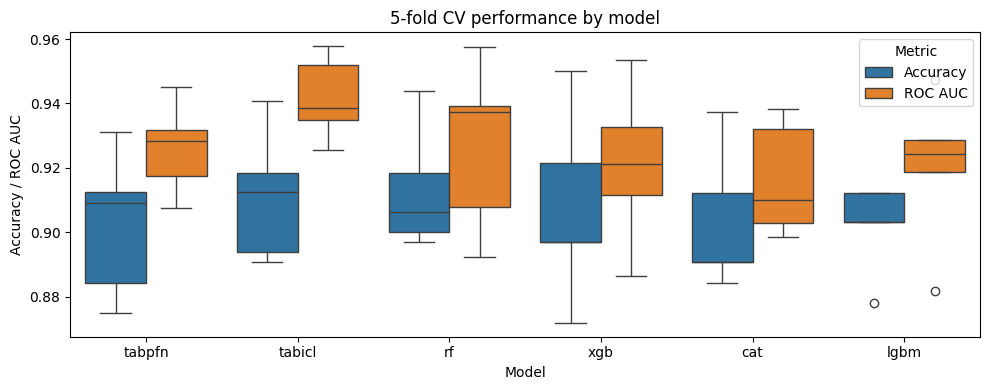

In [40]:

rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df")
    if cv is None or cv.empty:
        continue
    tmp = cv.copy()
    tmp["model"] = name
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric")

ax.set_xlabel("Model")
ax.set_ylabel("Accuracy / ROC AUC")
ax.set_title("5-fold CV performance by model")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()
